In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [2]:
D = np.load('drifting_gratings_data.npz')
binned_spikes = D['binned_spikes']
stim = D['stim_array']
CCmaxs = D['CCmaxs']
bin_len = 0.01

D = np.load('cell_types71.npz')
cell_types = D['cell_types']

In [3]:
ord_idxs = np.argsort(CCmaxs)[-30:]
ord_idxs = np.concatenate((ord_idxs[:-12],ord_idxs[-11:-6],ord_idxs[-5:]))
ord_types = cell_types[ord_idxs]
print np.unique(cell_types[ord_idxs],return_counts=True)
print CCmaxs[ord_idxs[-1]]

(array(['exc_VISp_1', 'exc_VISp_5', 'inh_VISp_1', 'inh_VISp_4',
       'inh_VISp_5'], dtype='|S10'), array([ 3,  3,  4,  2, 16]))
0.9199474554408273


In [8]:

# given binned spikes all of the same type
def construct_Xdsn(flat_stimulus, binned_spikes, d):
    (N,T) = binned_spikes.shape # N is number of neurons, T is number of time bins
    (M,T1) = flat_stimulus.shape # M is the size of a stimulus
    assert T==T1, "arrays have different number of time samples"
    X_dsn = np.ones(((T-d)*N,M*N+d+1))
    for n in range(N):
        for t in range(T-d):
            X_dsn[(T-d)*n+t,n*M:(n+1)*M] = flat_stimulus[:,t+d].reshape((1,-1))  #stimulus inputs
        for t in range(T-d):
            X_dsn[(T-d)*n+t,N*M:-1] = np.flip(binned_spikes[n,t:t+d],0).reshape((1,-1)) #spike inputs
    y = binned_spikes[:,d:].T.reshape((1,-1)).T
    return X_dsn,y

def fit_GLM(stim,spks,d):
    (X,y) = construct_Xdsn(stim,spks,d)
    model =  sm.GLM(y,X,family = sm.families.Poisson())
    model_results = model.fit()
    p = model_results.params
    se = model_results.bse
    b = p[-1]
    bse = se[-1]
    stim_filts = p[:-1-d].reshape((spks.shape[0],-1))
    stim_ses = se[:-1-d].reshape((spks.shape[0],-1))
    spk_filt = p[-1-d:-1]
    spk_se = se[-1-d:-1]
    normnegloglike = -model_results.llf/y.size
    return stim_filts, spk_filt, b, stim_ses, spk_se, bse, normnegloglike

def val_GLM(stim,spks,d,stim_filt,spk_filt,b):
    model =  sm.GLM(spks[0,d:],construct_Xdsn(stim,spks,d),family = sm.families.Poisson())
    return -model.loglike(np.concatenate((stim_filt,spk_filt,np.expand_dims(b,0))))/(spks.shape[-1]-d)

In [5]:
d = 30
conds = np.unique(stim,axis=1)  
mod_stim = np.zeros((conds.shape[1],stim.shape[1]))
for t in range(stim.shape[1]):
    ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
    mod_stim[ind,t] = 1

In [ ]:
conds = np.unique(stim,axis=1)  
mod_stim2 = np.zeros((2*conds.shape[1]-1,stim.shape[1]))
ind_old = -1
for t in range(stim.shape[1]):
    if stim[0,t]>0:
        ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
        if ind!=ind_old:
            t0=t
            ind_old=ind
        mod_stim2[(ind-1)*2,t] = np.cos(2.0*np.pi*stim[0,t]*(t-t0)*bin_len)
        mod_stim2[(ind-1)*2+1,t] = np.sin(2.0*np.pi*stim[0,t]*(t-t0)*bin_len)
    else:
        mod_stim2[-1,t] = 1
        ind_old = -1

(-0.5, 79999.5, 70.5, -0.5)

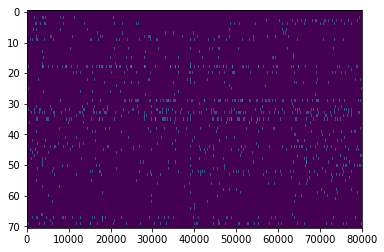

In [40]:
# print np.unique(mod_stim2)
x = np.hstack((mod_stim[:,:64000],mod_stim[:,156000:224000],mod_stim[:,316000:]))
# plt.imshow(x,cmap='Greys')
plt.imshow(binned_spikes[:,:80000])
plt.axis('tight')

In [31]:
A = np.arange(8).reshape(2,4)
print A, A.T.reshape(1,-1)

[[0 1 2 3]
 [4 5 6 7]] [[0 4 1 5 2 6 3 7]]


0.39432315152449876 10782863278.08911 161428401141.26196


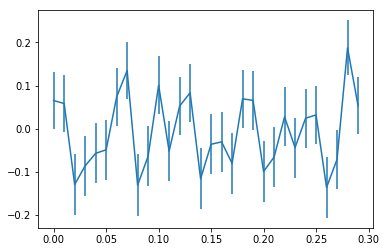

In [10]:
# stim_filt, spk_filt, b, stim_se, spk_se, bse = fit_GLM(mod_stim/np.sum(mod_stim,axis=1,keepdims=True),np.expand_dims(binned_spikes[-1,:],0),d)
stim_filt, spk_filt, b, stim_se, spk_se, bse, nnll = fit_GLM(mod_stim[:,:5000],binned_spikes[ord_idxs[ord_types=='exc_VISp_5'],:5000],d)

plt.errorbar(np.arange(d)*bin_len,spk_filt,yerr=spk_se)
print nnll,b, bse

2.2693186106475842 0.07215660171059608


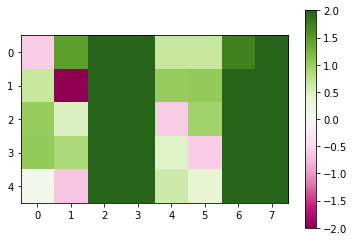

In [28]:
print stim_filt[0], stim_se[0]
plt.imshow(stim_filt[1:].reshape(5,8),cmap='PiYG',vmin=-2,vmax=2)
# print stim_filt[-1], stim_se[-1]
# plt.imshow(np.sqrt(np.square(stim_filt[0:-1:2])+np.square(stim_filt[1:-1:2])).reshape(5,8))
plt.colorbar()

# plt.errorbar(np.arange(stim_filt.size),stim_filt,yerr=stim_se)

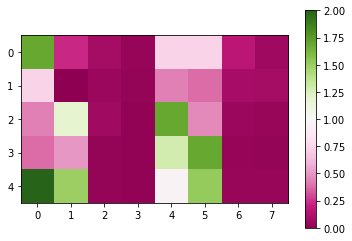

In [26]:
plt.imshow((stim_se[1:]/np.abs(stim_filt[1:])).reshape(5,8), vmin=0, vmax=2,cmap='PiYG')
# plt.imshow(np.sqrt(np.square(stim_se[0:-1:2])+np.square(stim_se[1:-1:2])).reshape(5,8))
plt.colorbar()

In [ ]:
import gc
split_ind = 280000#-5000
# train_nnlls = []
# val_nnlls = []
for idx in ord_idxs[-30+19:]:
    stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll = fit_GLM(mod_stim[:,:split_ind]/100,np.expand_dims(binned_spikes[idx,:split_ind],0),d)
    train_nnlls.append(train_nnll)
    val_nnll = val_GLM(mod_stim[:,split_ind:]/100,np.expand_dims(binned_spikes[idx,split_ind:],0),d,stim_filt, spk_filt, b)
    val_nnlls.append(val_nnll)
    print len(val_nnlls)
    gc.collect()
    

19
20
21
22
23
24


In [ ]:
lims = [0,1]
plt.plot(val_nnlls,train_nnlls,'o')
plt.plot(lims,lims)
plt.axis('square')
plt.xlim(lims)
plt.ylim(lims)


In [ ]:
np.savez('drifting_gratings_indivfit1',train_nnlls = np.array(train_nnlls), val_nnlls = np.array(val_nnlls))